### Import required libraries

In [1]:
# start with common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Read in the data

In [2]:
data = pd.read_csv('../data/crime_data_model.csv')

data.shape

(549861, 16)

### Split the data into training, validation and test sets

In [25]:
from fast_ml.model_development import train_valid_test_split

# Split the data
X = data.drop('cleared', axis=1)
y = data['cleared']

# define the train, validation and test size
train_size = 0.7
valid_size = 0.1
test_size = 0.2

X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(data, target = 'cleared', 
                                                                            train_size=train_size, valid_size=valid_size, test_size=test_size)

# check the shape of the data
print('Training set shape: ', X_train.shape)
print('Validation set shape: ', X_valid.shape)
print('Test set shape: ', X_test.shape)

Training set shape:  (384902, 15)
Validation set shape:  (54986, 15)
Test set shape:  (109973, 15)


### Encode the target variable

In [5]:
from sklearn.preprocessing import LabelEncoder
# encode the target variable

# instantiate the label encoder
le = LabelEncoder()

# fit and transform the target variable
y_train = le.fit_transform(y_train)
y_valid = le.transform(y_valid)
y_test = le.transform(y_test)

### Create ML Pipelines

### Natural Language Processing
### Create custom transformers for the text data
We will execute a few techniques with the text data to make it ready for the model. We will use the following techniques:
- Tokenization - converting text into tokens
- Removing Stopwords - removing common words that will likely appear in any text
- Lemmatization - converting words to their base form
- Stemming - reducing words to their root form
- n-grams - grouping words together (for example, instead of having "good" and "movie" as separate tokens, we can have "good movie" as one token)

In [6]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class NltkPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def tokenize_and_stem(self, text):
        stop_words = set(stopwords.words('english'))
        stemmer = PorterStemmer()
        tokens = word_tokenize(text)
        tokens = [token for token in tokens if token not in stop_words]
        stems = [stemmer.stem(token) for token in tokens]
        return ' '.join(stems)

    def transform(self, X, y=None):
        # Convert X to a pandas Series if it's a numpy array
        if isinstance(X, np.ndarray):
            X = pd.Series(X.flatten())

        return X.apply(self.tokenize_and_stem)

### Build the different column transformers
There are 3 text columns in the dataset. We will build a column transformer for each of these columns. We will use the custom transformers we created earlier in the column transformers, to pre-process the text

In [7]:
# import required libraries
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier


# define the categorical preprocessor
cat = ['AREANAME', 'VictSex', 'TIME_OF_DAY','VictDescent','crime_category','crime_type']
cat_transforms = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]

)

# define the numeric preprocessor
num = ['VictAge','YEAR', 'MONTH', 'DAY', 'HOUR','REPORTING_DELAY']
num_transforms = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('scaler', StandardScaler())
    ]
)

# define the text preprocessor
txt1 = ['PremisDesc']
txt1_transforms = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='')),
        ('preprocessor', NltkPreprocessor()),
        ('vectorizer', CountVectorizer(max_features=200,
                                        min_df=0.001
                                        ))
    ]
)

# define the text preprocessor
txt2 = ['WeaponDesc']
txt2_transforms = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='')),
        ('preprocessor', NltkPreprocessor()),
        ('vectorizer', CountVectorizer(max_features=200,
                                        min_df=0.001
                                        ))
    ]
)

# define the text preprocessor
txt3 = ['CrmCdDesc']
txt3_transforms = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='')),
        ('preprocessor', NltkPreprocessor()),
        ('vectorizer', CountVectorizer(max_features=200,
                                        min_df=0.001
                                        ))
    ]
)

# define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transforms, num),
        ('cat', cat_transforms, cat),
        ('txt1', txt1_transforms, ['PremisDesc']),
        ('txt2', txt2_transforms, ['WeaponDesc']),
        ('txt3', txt3_transforms, ['CrmCdDesc'])
    ]
)

# Now you can fit the preprocessor
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('scaler', StandardScaler())]),
                                 ['VictAge', 'YEAR', 'MONTH', 'DAY', 'HOUR',
                                  'REPORTING_DELAY']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['...
                                                  SimpleImputer(fill_value='',
                                                                strategy='constant')),
                                                 ('preprocessor',
                                                  NltkPreprocessor()),
                                                 ('vectorizer',
                                                  CountVectorizer(max_features=200,
                                                                  min_df=0.001))]),
                                 ['WeaponDesc']),
                                ('txt3',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='',
                                                                strategy='constant')),
                                                 ('preprocessor',
                                                  NltkPreprocessor()),
                                                 ('vectorizer',
                                                  CountVectorizer(max_features=200,
                                                                  min_df=0.001))]),
                                 ['CrmCdDesc'])])

### Fit the model

In [8]:
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier


# define the classifier
clf = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(n_estimators=100, random_state=0))
    ]
)

# define the parameter grid
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.001, 0.01, 0.1],
}

# instantiate the grid search - The code doesn't support parallel execution, there is an issue in the text prepprocessor
# until the issue is resolved, set n_jobs=1 - estimated runtime is about 458 minutes on a 10 core machine
grid_search = GridSearchCV(clf, param_grid=param_grid, n_jobs=1, verbose=3, return_train_score=True)

# 
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END classifier__learning_rate=0.001, classifier__n_estimators=100;, score=(train=0.860, test=0.860) total time= 2.7min
[CV 2/5] END classifier__learning_rate=0.001, classifier__n_estimators=100;, score=(train=0.860, test=0.860) total time= 2.6min
[CV 3/5] END classifier__learning_rate=0.001, classifier__n_estimators=100;, score=(train=0.860, test=0.860) total time= 2.6min
[CV 4/5] END classifier__learning_rate=0.001, classifier__n_estimators=100;, score=(train=0.860, test=0.860) total time= 2.6min
[CV 5/5] END classifier__learning_rate=0.001, classifier__n_estimators=100;, score=(train=0.860, test=0.860) total time= 2.7min
[CV 1/5] END classifier__learning_rate=0.001, classifier__n_estimators=200;, score=(train=0.860, test=0.860) total time= 6.9min
[CV 2/5] END classifier__learning_rate=0.001, classifier__n_estimators=200;, score=(train=0.860, test=0.860) total time= 2.6min
[CV 3/5] END classifier__learning_rate=0.001

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['VictAge',
                                                                          'YEAR',
                                                                          'MONTH',
                                                                          'DAY',
                                                                          'HOUR',
                                                                          'REPORTING_DELAY']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constan...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=0, ...))]),
             n_jobs=1,
             param_grid={'classifier__learning_rate': [0.001, 0.01, 0.1],
                         'classifier__n_estimators': [100, 200, 300]},
             return_train_score=True, verbose=3)

In [10]:
# get the best params
grid_search.best_params_


{'classifier__learning_rate': 0.1, 'classifier__n_estimators': 300}

In [11]:
# evaluate the model
from sklearn.metrics import accuracy_score


# predict the target variable
y_test_pred = grid_search.predict(X_test)



display('Test accuracy: %.2F' %  accuracy_score(y_test, y_test_pred))

'Test accuracy: 0.89'

In [12]:
# get precision, recall and f1 score
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94     94756
           1       0.70      0.31      0.43     15217

    accuracy                           0.89    109973
   macro avg       0.80      0.64      0.68    109973
weighted avg       0.87      0.89      0.87    109973



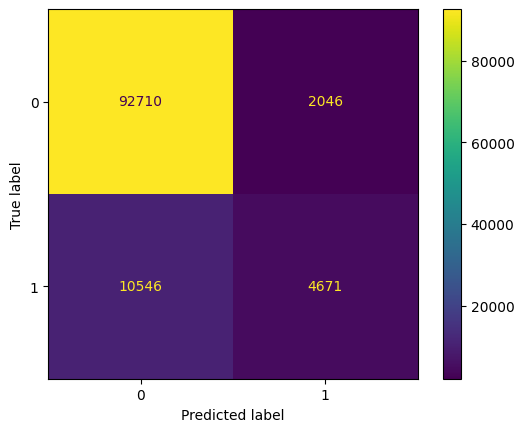

In [13]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot()


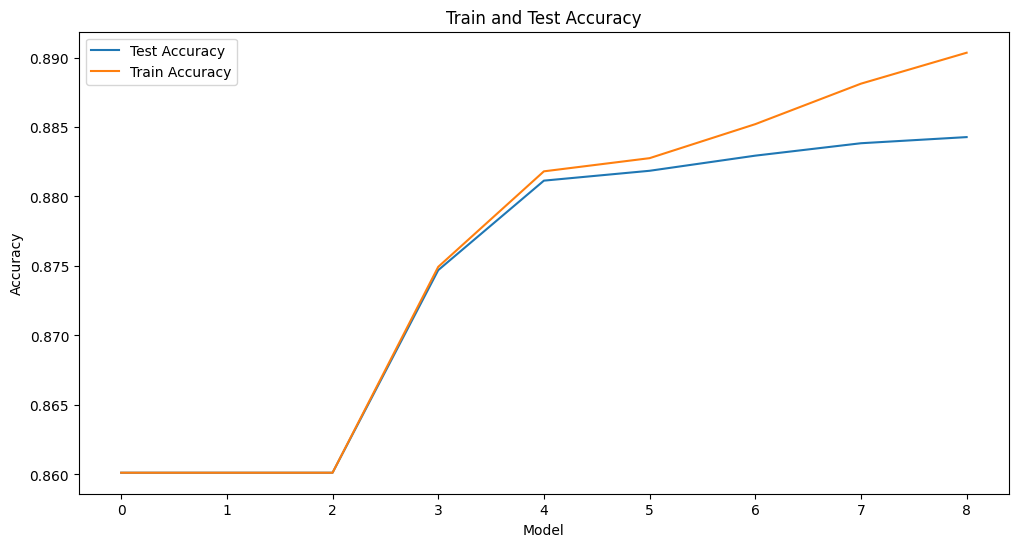

In [14]:
# plot the training and test accuracy 
plt.figure(figsize=(12, 6))
plt.plot(grid_search.cv_results_['mean_test_score'], label='Test Accuracy')
plt.plot(grid_search.cv_results_['mean_train_score'], label='Train Accuracy')
plt.legend()
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.show()


### Now we will run the model with the best params and use the eval set to evaluate the model

In [ ]:
# retrieve performance metrics
results = clf.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

# plot log loss and classification error 
fig, axs = plt.subplots(ncols=2, figsize=(18, 5))

# plot log loss
axs[0].plot(x_axis, results['validation_0']['error'], label='Train')
axs[0].plot(x_axis, results['validation_1']['error'], label='Test')
axs[0].legend()
axs[0].set_ylabel('Error')
axs[0].set_title('XGBoost Error', fontsize=16)

# plot classification error
axs[1].plot(x_axis, results['validation_0']['auc'], label='Train')
axs[1].plot(x_axis, results['validation_1']['auc'], label='Test')
axs[1].legend()
axs[1].set_ylabel('AUC')
axs[1].set_title('XGBoost AUC', fontsize=16)

plt.show()


In [ ]:
txt1_transforms.fit(X_train[['PremisDesc']])

transformed_text = txt1_transforms.transform(X_train[['PremisDesc']])

# get the feature names
feature_names = txt1_transforms.named_steps['vectorizer'].get_feature_names_out()

# create a dataframe
txt1_df = pd.DataFrame(transformed_text.toarray(), columns=feature_names)

print('Shape of the transformed text: ', txt1_df.shape)
display(txt1_df[:5])

In [ ]:
txt2_transforms.fit(X_train[['WeaponDesc']])

transformed_text = txt2_transforms.transform(X_train[['WeaponDesc']])

# get the feature names
feature_names = txt2_transforms.named_steps['vectorizer'].get_feature_names_out()

# create a dataframe
txt2_df = pd.DataFrame(transformed_text.toarray(), columns=feature_names)

print('Shape of the transformed text: ', txt2_df.shape)
display(txt2_df.head())